In [1]:
library(tidyverse)
library(stringr)
options(jupyter.rich_display=T)
library(harrypotter)
library(tidytext)
options(repr.plot.width=4, repr.plot.height=3)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# STATS 306
## Problem Set 5: Text Analysis
This problem set is shorter than usual because of the midterm. It contains five problems, each worth one point each.

### Sentiment Analysis
In problems 1-2 we will perform *sentiment analysis* of the Harry Potter books. The file `afinn.RData` contains a sentiment score for a large number of words in the English language:

In [2]:
load("afinn.RData")
print(afinn)

# A tibble: 2,477 x 2
   word       value
   <chr>      <dbl>
 1 abandon       -2
 2 abandoned     -2
 3 abandons      -2
 4 abducted      -2
 5 abduction     -2
 6 abductions    -2
 7 abhor         -3
 8 abhorred      -3
 9 abhorrent     -3
10 abhors        -3
# … with 2,467 more rows


Negatively connoted words receive low scores, while positively connoted words receive high scores:

In [3]:
filter(afinn, word %in% c("death", "hurrah"))

word,value
<chr>,<dbl>
death,-2
hurrah,5


By joining this table to other tables containing text data and summarizing, we can generate scores of how positive or negative the text is.

#### Problem 1
The `tidytext::unnest_tokens()` function can be used to break a chunk of text into "tokens" (words, sentences, etc.) It works as follows. Consider the following tibble, which contains all 17 chapters of the first book in the Harry Potter series:

In [4]:
phil_tbl <- tibble(chapter=seq_along(philosophers_stone), 
                   text=philosophers_stone) %>% print

# A tibble: 17 x 2
   chapter text                                                                 
     <int> <chr>                                                                
 1       1 "THE BOY WHO LIVED　　Mr. and Mrs. Dursley, of number four, Privet Dri…
 2       2 "THE VANISHING GLASS　　Nearly ten years had passed since the Dursleys…
 3       3 "THE LETTERS FROM NO ONE　　The escape of the Brazilian boa constricto…
 4       4 "THE KEEPER OF THE KEYS　　BOOM. They knocked again. Dudley jerked awa…
 5       5 "DIAGON ALLEY　　Harry woke early the next morning. Although he could …
 6       6 "THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS　　Harry's last mon…
 7       7 "THE SORTING HAT　　The door swung open at once. A tall, black-haired …
 8       8 "THE POTIONS MASTER　　There, look.\"　　\"Where?\"　　\"Next to the tall …
 9       9 "THE MIDNIGHT DUEL　　Harry had never believed he would meet a boy he …
10      10 "HALLOWEEN　　Malfoy couldn't believe his eyes when he saw that Harry …
11      1

To perform sentiment analysis, we need to break each chapter into words so that we can join it to the `afinn` table. This is what `unnest_tokens()` does:

In [5]:
phil_tok <- unnest_tokens(phil_tbl, input=text, output=word) %>% print

# A tibble: 77,875 x 2
   chapter word   
     <int> <chr>  
 1       1 the    
 2       1 boy    
 3       1 who    
 4       1 lived  
 5       1 mr     
 6       1 and    
 7       1 mrs    
 8       1 dursley
 9       1 of     
10       1 number 
# … with 77,865 more rows


Using this table and `afinn`, we can assign sentiment scores to various portions of text. For example:

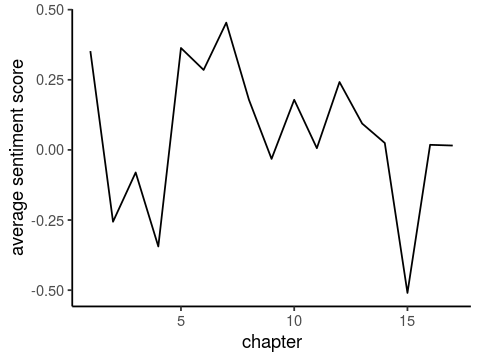

#### Problem 1
Some people say that the Harry Potter books became darker (more negative) over time. Use sentiment analysis to investigate this, and report your conclusion here. (Hint: A list of all the Harry Potter books can be obtained by looking at the help page for the `harrypotter` package.)

Joining, by = "word"
Joining, by = "word"


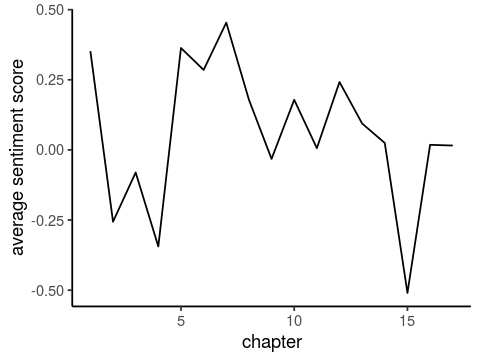

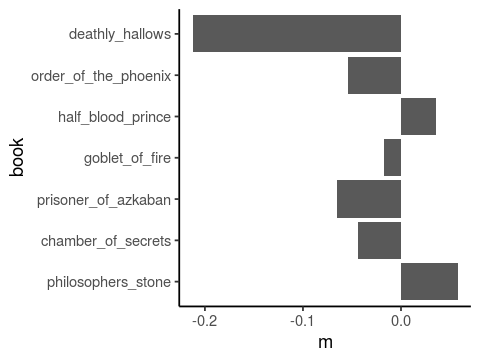

In [6]:
### BEGIN SOLUTION
phil_tok %>% inner_join(afinn) %>% 
    group_by(chapter) %>%
    summarize(frac_pos=mean(value)) %>%
    ggplot + geom_line(aes(x=chapter, y=frac_pos))  + theme_classic() + 
    ylab("average sentiment score")

books = c(
    "philosophers_stone",
    "chamber_of_secrets", 
    "prisoner_of_azkaban",
    "goblet_of_fire", 
    "half_blood_prince",
    "order_of_the_phoenix",
    "deathly_hallows"
)
map_dfr(books, ~ tibble(book=., chapter=seq_along(get(.)), text=get(.))) %>% 
    unnest_tokens(input=text, output=word) %>% 
    inner_join(afinn) %>% group_by(book) %>% 
    summarize(m=mean(value)) %>%
    mutate(book = factor(book, levels=books)) %>% 
    arrange(desc(book)) %>%
    ggplot + geom_col(aes(x=book, y=m)) + coord_flip() + theme_classic()
### END SOLUTION

### BEGIN SOLUTION

### END SOLUTION

#### Problem 2

According to the sentiment scores, what is the most negative/positive chapter in any of the Harry Potter books? 

Of the sentences that contain three or more scored words, what is the happiest (most positive)?

In [7]:
### BEGIN SOLUTION
books = c(
    "philosophers_stone",
    "chamber_of_secrets", 
    "prisoner_of_azkaban",
    "goblet_of_fire", 
    "half_blood_prince",
    "order_of_the_phoenix",
    "deathly_hallows"
)
map_dfr(books, ~ tibble(book=., chapter=seq_along(get(.)), text=get(.))) %>% 
    unnest_tokens(input=text, output=word) %>% 
    inner_join(afinn) %>% group_by(book, chapter) %>% 
    summarize(m=mean(value), am=abs(m)) %>%
    group_by(m>0) %>% 
    top_n(1, am)


map_dfr(books, ~ tibble(book=., chapter=seq_along(get(.)), text=get(.))) %>% 
    unnest_tokens(input=text, output=sentence, token="sentences") %>% 
    unnest_tokens(input=sentence, output=word, drop=F) %>% 
    inner_join(afinn) %>% 
    group_by(book, chapter, sentence) %>% 
    summarize(m = mean(value), am=abs(m), n=n()) %>%
    filter(n >= 3) %>%
    group_by(m>0) %>%
    top_n(1, am)

### END SOLUTION

Joining, by = "word"


book,chapter,m,am,m > 0
<chr>,<int>,<dbl>,<dbl>,<lgl>
half_blood_prince,9,0.6862745,0.6862745,TRUE
half_blood_prince,28,-1.1428571,1.1428571,FALSE


Joining, by = "word"


book,chapter,sentence,m,am,n,m > 0
<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<lgl>
deathly_hallows,2,"he wondered what his aunt and uncle would do with them; burn them in the dead of night, probably, as if they were evidence of some dreadful crime.",-3.0,3.0,3,FALSE
deathly_hallows,24,"""you turn up here with a dead house-elf and a half-conscious goblin, hermione looks as though she's been tortured, and ron's just refused to tell me anything ¨c """"we can't tell you what we're doing,"" said harry flatly.",-3.0,3.0,3,FALSE
deathly_hallows,31,"she concealed her loss, my dreadful betrayal, even from the other founders of hogwarts.""""",-3.0,3.0,3,FALSE
order_of_the_phoenix,13,"she's evil, he thought, as he climbed a staircase to the seventh floor, she's an evil, twisted, mad old- 'ron?'",-3.0,3.0,3,FALSE
order_of_the_phoenix,13,"this is your punishment for spreading evil, nasty, attention-seeking stories, mr potter, and punishments certainly cannot be adjusted to suit the guilty one's convenience.",-3.0,3.0,3,FALSE
order_of_the_phoenix,24,"maniacal laughter was ringing in his ears . . . he was happier than he had been in a very long time . . . jubilant, ecstatic, triumphant . . . a wonderful, wonderful thing had happened . . .",3.8,3.8,5,TRUE
order_of_the_phoenix,31,"he might as well have tried to see moving pictures on the desktop as in the stubbornly blank crystal ball; he lost his head completely during tea-leaf reading, saying it looked to him as though professor marchbanks would shortly be meeting a round, dark, soggy stranger, and rounded off the whole fiasco by mixing up the life and head lines on her palm and informing her that she ought to have died the previous tuesday.",-3.0,3.0,3,FALSE
order_of_the_phoenix,35,"don't let her be dead, don't let her be dead, it's my fault if she's dead . . .",-3.0,3.0,3,FALSE
prisoner_of_azkaban,2,"if there's something wrong with the bitch, there'll be something wrong with the pup --"" at that moment, the wineglass aunt marge was holding exploded in her hand.",-3.0,3.0,3,FALSE


### Reddit dataset
The file `reddit_xmas_2017.RData` contains 100,000 comments posted to Reddit on Christmas Day, 2017.

In [8]:
load('reddit_xmas_2017.RData')
reddit %>% print

# A tibble: 100,000 x 3
   author        body                                        created_utc        
   <chr>         <chr>                                       <dttm>             
 1 br_shadow     Thank you for this, there is a person writ… 2017-12-25 15:49:08
 2 Ksalol        They are not to quick actually. It's mainl… 2017-12-25 17:42:50
 3 itscool83     tell her you guys should hang out when you… 2017-12-25 18:54:13
 4 Glu7enFree    "Autism is a high honor in the tech savvy … 2017-12-25 07:48:17
 5 Theotheogrea… "You thought a cat was your son?! "         2017-12-25 20:58:08
 6 Shadrac121    Hopfully she takes wat people say in and m… 2017-12-25 22:27:31
 7 1fzUjhemoSB1… Si ce propui sa facem cu toata pielea rama… 2017-12-25 07:41:31
 8 MinisterOfEd… "I don't mean to be impolite, but if you'r… 2017-12-25 19:28:35
 9 AabidS10      i dont have a 720p x265 of it, sorry. i be… 2017-12-25 13:20:32
10 S3RG10        "I'm dying to try Guatemalan sandals and w… 2017-12-25 00:48:46
# … 

Problems 3-5 ask you questions about this data set. Unless specified otherwise, all matches are case insensitive.

(*Disclaimer*: I filtered out objectionable comments as best I could, but you may find more if you dig around this data for long enough.)

#### Problem 3
Comment 174 wishes everyone a happy holidays:

In [9]:
reddit %>% slice(174)

author,body,created_utc
<chr>,<chr>,<dttm>
Bareilles,Thank you. Happy holidays everyone!,2017-12-25 01:33:50


What are other people wishing? Count the first occurrence of the string "Happy `<word>`" or "Merry `<word>`" in the comment body, if any, count the matches. 

To keep things interesting, do *not* include phrases matching `(happy|merry) (to|with|for|about|and|that|if|i|you|when)`. 

Print a table containing the top 20 matches; a few of the rows are:

<table>
<thead>
    <tr><th scope="col">greeting</th><th scope="col">n</th></tr>
    <tr><th scope="col">&lt;chr&gt;</th><th scope="col">&lt;int&gt;</th></tr>
</thead>
<tbody>
    <tr><td>merry christmas</td><td>2040</td></tr>
    <tr><td>happy holidays </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td> &mdash;</td></tr>
    <tr><td>&mdash;        </td><td>   7</td></tr>
    <tr><td>happy cakeday  </td><td>   6</td></tr>
</tbody>
</table>

Your numbers may vary slightly depending on how you performed the match.

In [10]:
### BEGIN SOLUTION
reddit %>%
    mutate(greeting = str_extract(str_to_lower(body), 
                                  "(happy|merry) \\w+")) %>% 
    filter(!is.na(greeting)) %>% count(greeting) %>% 
    filter(!str_detect(greeting, '(happy|merry) (to|with|for|about|and|that|if|i|you|when)')) %>%
    arrange(-n) %>% slice(1:10) 
### END SOLUTION

greeting,n
<chr>,<int>
merry christmas,2040
happy holidays,477
merry xmas,93
happy christmas,44
happy cake,28
happy birthday,23
happy new,15
happy holiday,13
merry x,7


#### Problem 4
The number of hourly mentions of the word `christmas`or `xmas` is:
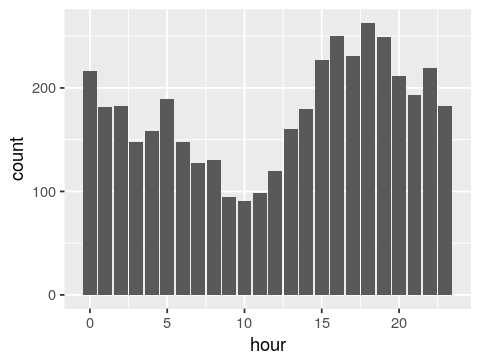

Make a similar plot for hourly mentions of any word which contains "snow" or "flakes".


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



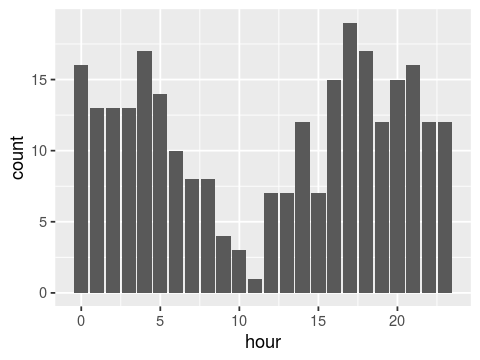

In [11]:
### BEGIN SOLUTION
library(lubridate)
options(repr.plot.width=4, repr.plot.height=3)
reddit %>% mutate(hour=hour(created_utc)) %>% 
           filter(str_detect(body, regex("snow|flakes", ignore_case = T))) %>% 
           ggplot + geom_bar(aes(x=hour))
### END SOLUTION

#### Problem 5
The most common word in the comments is "the", which occurs 81,104 times.

In [12]:
reddit %>% mutate(c=str_count(str_to_lower(body), '\\bthe\\b')) %>% summarize(sum(c))

sum(c)
<int>
81104


The word `christmas` occurs 4265 times:

In [13]:
xmas_re <- regex('\\bchristmas\\b', ignore_case = T)
reddit %>% mutate(c=str_count(body, xmas_re)) %>% summarize(sum(c))

sum(c)
<int>
4265


What is the next most common word after Christmas, and how many times does it appear?

In [18]:
### BEGIN SOLUTION
ds <- reddit %>% mutate(words=str_extract_all(body, regex("\\b[a-z']+\\b", ignore_case = T))) %>%
                 unnest %>% mutate(words = str_to_lower(words)) %>% count(words) %>% 
                 arrange(desc(n)) %>% mutate(k=row_number())
filter(ds, words == "christmas")
filter(ds, k == 77)
### END SOLUTION

words,n,k
<chr>,<int>,<int>
christmas,4264,76


words,n,k
<chr>,<int>,<int>
only,4151,77
